## Identifikasi Emosi Pengguna dengan Pendekatan ERT

### Persiapan Pemrosesan

Melakukan install library yang dibutuhkan untuk proses identifikasi emosi komunitas pengguna

In [ ]:
#!pip install flair

In [ ]:
#!pip install swifter

Melakukan import library yang dibutuhkan

In [ ]:
import torch
import swifter
import re
import string
import ast
import glob
import json
import random
import collections
import datetime
import gensim
import forceatlas2 
import lemmatizer as lemma
import seaborn as sns
import pandas as pd
import numpy as np

import networkx.algorithms.community as nx_comm
from operator import itemgetter
from networkx.readwrite import json_graph
from scipy import stats
from datetime import datetime
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms import community 
from itertools import combinations


from nltk.corpus import stopwords
from nltk.probability import FreqDist

# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from matplotlib import pyplot as plt
from wordcloud import STOPWORDS
from wordcloud import WordCloud 
from operator import itemgetter
from scipy import stats
from datetime import datetime

#Import modules
%matplotlib inline

#for network creation
import networkx as nx

Melakukan koneksi ke Google Drive untuk mengakses sumber data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Melakukan import data pengguna representatif berdasarkan cluster pengguna

In [ ]:
cluster_number = 23

# import data  tweet user
#before covid
# cluster = [4, 44, 53, 54, 77]
#tweet_data_df = pd.read_csv("dataset/output/noncovid/cluster_{}.csv".format(cluster_number))

#after covid
#cluster = [0, 1, 23]
tweet_data_df = pd.read_csv("dataset/output/covid/cluster_{}.csv".format(cluster_number))

### Mekanisme Promrosesan Teks

Mekanisme ini digunakan untuk mendapatkan representasi kata adjektiva dari setiap tweet pengguna yang digunakan untuk proses deteksi emosi dengan InSet Lexicon

**1. Proses Pemilihan Periodik Data**

Memilih periode data. Pada penelitian ini, periode data yang digunakan adalah 3 bulan pada periode sebelum COVID-19 dan 3 bulan periode setelah COVID-19

In [ ]:
final_selected_data_df = tweet_data_df.copy()
final_selected_data_df = final_selected_data_df[['tweet_id', 'username', 'date', 'time', 'tweet', 'period', 'topic_predict', 'cluster', 'emotion', 'sentiment']]
final_selected_data_df.head(5)

,tweet_id,username,date,time,tweet,period,topic_predict,cluster,emotion,sentiment
0,1245013478655422464,destiyanar12,2020-03-31,15:41:59,"Mo mencoba untuk tdr,semoga berhasil.",covid,11,3,happy,neutral
1,1244939607487078400,destiyanar12,2020-03-31,10:48:26,Bego emg beli obat malah ditinggal dikerjaan,covid,16,0,anger,negative
2,1244644802928373760,destiyanar12,2020-03-30,15:17:00,Knpa gaterima gt kalo gue blg diri gue anak ru...,covid,6,3,anger,negative
3,1244589963687030784,destiyanar12,2020-03-30,11:39:05,"@saviralisdianap Sono lo jd relawan aja,drpd d...",covid,6,3,anger,negative
4,1244584343474802688,destiyanar12,2020-03-30,11:16:45,"Semenjak ada corona gue plg kerja bnr2 drmh,kl...",covid,1,0,sadness,negative


In [ ]:
len(final_selected_data_df)

747

**2. Tahapan Pemrosesa Teks**

**2.1. Case Folding**

Case folding bertujuan untuk mengubah semua huruf dalam sebuah dokumen teks menjadi huruf kecil (lowercase)

In [ ]:
# gunakan fungsi Series.str.lower() pada Pandas
def case_folding(tweet_data_df):
    tweet_data_df['tweet_char'] = tweet_data_df['tweet'].str.lower()
    
    return tweet_data_df

**2.2. Menghapus Spesial Karakter**

Proses ini digunakan untuk menghapus number, link, punctuation, single char, space, entities, mention, hastag dan karakter spesial lain.

In [ ]:
def remove_tweet_special(text):
    # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    # Remove every retweet symbol
    text = re.sub('(?i)rt',' ',text)
    # Remove every username
    text = re.sub('@[^\s]+[ \t]','',text)
     # Remove every username
    text = re.sub('(?i)user','',text)
    # Remove every url
    text = re.sub('(?i)url',' ',text)
    # Remove every emoji
    text = re.sub(r'\\x..',' ',text)
    # Remove extra spaces
    text = re.sub('  +', ' ', text)
    #Remove characters repeating more than twice
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) 
    
    return text

def strip_links(text):
    # remove link
    text = re.sub(r'pic.twitter.com.[\w]+', '', text) # Remove every pic 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', text)
    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def special_char(tweet_data_df):
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_tweet_special)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(strip_links)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(strip_all_entities)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_number)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_punctuation)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_whitespace_LT)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_whitespace_multiple)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_singl_char)
    
    return tweet_data_df

**2.3 Tokenizing**

*Tokenizing* adalah operasi memisahkan teks menjadi potongan-potongan berupa token, bisa berupa potongan huruf, kata, atau kalimat, sebelum dianalisis lebih lanjut. Entitas yang bisa disebut sebagai token misalnya kata, angka, simbol, tanda baca, dan lain sebagainya

In [ ]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)
    
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

def tokenizing(tweet_data_df):
    #tweet_data_df['tweet_tokens'] = tweet_data_df['tweet'].apply(word_tokenize_wrapper)
    tweet_data_df['tweet_tokens'] = list(sent_to_words(tweet_data_df['tweet_char']))
    tweet_data_df['tweet_tokens'] = make_n_grams(tweet_data_df['tweet_tokens'])
    
    return tweet_data_df

**2.4 Filtering (Stopword Removal)**

Menghilangkan kata umum (*common words*) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.

In [ ]:
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')

# append additional stopword
#list_stopwords.extend(['test'])

# read txt stopword using pandas

txt_stopword1 = pd.read_csv("resources/stopwords/stopwords.txt", names= ["stopwords"], header = None)
txt_stopword2 = pd.read_csv("resources/stopwords/stopword2.txt", names= ["stopwords"], header=None)
txt_stopword3 = pd.read_csv("resources/unimportant text/unimportant-text.txt", names= ["stopwords"], header=None)
txt_stopword4 = pd.read_csv("resources/stopwords/stopwords4.csv", names= ["stopwords"], header = None)
txt_stopword5 = pd.read_csv("resources/unimportant text/other-unimportant-text.txt", names= ["stopwords"], header=None)

txt_stopword1 = txt_stopword1["stopwords"][0].split(' ')
txt_stopword2 = txt_stopword2["stopwords"][0].split(' ')
txt_stopword3 = txt_stopword3["stopwords"][0].split(' ')
txt_stopword4 = txt_stopword4["stopwords"][0].split(' ')
txt_stopword5 = txt_stopword5["stopwords"][0].split(' ')
        
# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword1)
list_stopwords.extend(txt_stopword2)
list_stopwords.extend(txt_stopword3)
list_stopwords.extend(txt_stopword4)
list_stopwords.extend(txt_stopword5)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    #words = ast.literal_eval(words)
    
    #filtered_sentence = [word for word in words if not word in list_stopwords]
    filtered_sentence = [] 
    
    for word in list(words):
        tokens = word.split(' ')
        
        if len(tokens)> 1:
            for token in list(tokens):
                if token not in list_stopwords: 
                    filtered_sentence.append(token) 
            
        else:
            if word not in list_stopwords: 
                filtered_sentence.append(word) 
    
    return filtered_sentence
        
#function
def stopwords_process_first(tweet_data_df):
    tweet_data_df['tweet_tokens'] = (tweet_data_df['tweet_tokens'].apply(stopwords_removal))
    
    return tweet_data_df

def stopwords_process_second(tweet_data_df):
    tweet_data_df['tweet_final_tokens'] = (tweet_data_df['tweet_tokens_lemma'].apply(stopwords_removal))

    return tweet_data_df

**2.5 Normalization**

Normalization digunakan untuk menyeragamkan term yang memiliki makna sama namun penulisanya berbeda, bisa diakibatkan kesalahan penulisan, penyingkatan kata, ataupun “bahasa gaul”.

In [ ]:
#file1
normalizad_word1 = pd.read_csv("resources/slang words/colloquial-indonesian-lexicon.txt")
#file2
normalizad_word2 = pd.read_csv("resources/slang words/kamusalay.csv", header=None)
#file3
file = open("resources/slang words/combined_slang_words.txt", "r")
contents = file.read()
normalizad_word3 = ast.literal_eval(contents)
file.close()
#file4
normalizad_word4 = pd.read_csv("resources/slang words/kamusalay.csv", header=None)
#file5
normalizad_word5 = pd.read_csv('resources/slang words/kbba.txt', sep="\t", header=None)

normalizad_word_dict = {}

for index, row in normalizad_word1.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
for index, row in normalizad_word2.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
for index in normalizad_word3.keys():
    if index not in normalizad_word_dict:
        normalizad_word_dict[index] = normalizad_word3[index]

for index, row in normalizad_word4.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]
        
for index, row in normalizad_word5.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

def normalization(tweet_data_df):
    tweet_data_df['tweet_normalized'] = tweet_data_df['tweet_tokens'].swifter.apply(normalized_term)
    
    return tweet_data_df

**2.6 Stemming**

Function stemmer dari library Sastrawi untuk mengembalikan kata kebentuk dasarnya. Karena fungsi stemmer.stem() pada library Sastrawi lambat, kita dapat menggunakan library swifter untuk mempercepat froses stemming pada Dataframe dengan menjalankan task secara parallel. Kecepatan pemrosesan bisa dua kali bahkan lebih cepat jika tanpa menggunakan swifter.

In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

def stemming(tweet_data_df):
    for document in tweet_data_df['tweet_normalized']:
        for term in document:
            if term not in term_dict:
                term_dict[term] = ' '

    for term in term_dict:
        term_dict[term] = stemmed_wrapper(term)
        #print(term,":" ,term_dict[term])

    tweet_data_df['tweet_tokens_stemmed'] = tweet_data_df['tweet_normalized'].swifter.apply(get_stemmed_term)
    #print(tweet_data_df['tweet_tokens_stemmed'])

    return  tweet_data_df

**2.7 Lemmatization**

*Lemmatization* adalah proses kategorisasi kata yang tidak bentuk kata dasar yang yang sama, tetapi masih memiliki makna yang sama.

In [ ]:
def lemmatization_process(tweet_data_df):
    lem = lemma.Lemmatizer()
    _stopwords_ = stopwords.words('indonesian')
    
    lemmatized_sent = []
    
    try:
        for token in tweet_data_df:
            lemmatized = lem.lemmatize(token)

            if(type(lemmatized) == tuple):
                lemmatized_sent.append(lemmatized[0])
            else:
                lemmatized_sent.append(lemmatized)
    except:
            lemmatized_sent.append('')
            
    return lemmatized_sent
    
def lemmatization(tweet_data_df):
            
    tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_stemmed'].swifter.apply(lemmatization_process)

    return  tweet_data_df

**2.8. POS Tagging**

Pada bagian ini, proses POS Taging dilakukan mendapatkan frasa kata adjektiva yang merepresentasikan emosi pengguna.

In [ ]:
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask
corpus = NLPTaskDataFetcher.load_corpus(NLPTask.UD_INDONESIAN)

tag_type = 'upos'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, BertEmbeddings
from typing import List

from flair.data import Sentence
from flair.models import SequenceTagger

embedding_types: List[TokenEmbeddings] = [ 
    WordEmbeddings('id-crawl'),
    WordEmbeddings('id'),
]
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

from flair.models import SequenceTagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                      tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

2022-04-08 18:44:55,790 Reading data from /Users/toniafriantoni/.flair/datasets/ud_indonesian
2022-04-08 18:44:55,791 Train: /Users/toniafriantoni/.flair/datasets/ud_indonesian/id_gsd-ud-train.conllu
2022-04-08 18:44:55,792 Dev: /Users/toniafriantoni/.flair/datasets/ud_indonesian/id_gsd-ud-dev.conllu
2022-04-08 18:44:55,793 Test: /Users/toniafriantoni/.flair/datasets/ud_indonesian/id_gsd-ud-test.conllu


/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) load_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  


In [ ]:
#tag_pos = SequenceTagger.load('/content/drive/MyDrive/Thesis/resources/taggers/example-universal-pos/best-model.pt')
tag_pos = SequenceTagger.load('resources/taggers/example-universal-pos/best-model.pt')

2022-04-08 18:45:08,428 loading file resources/taggers/example-universal-pos/best-model.pt


In [ ]:
#exceptional_word = ['corona','coronavirus','covid','ncov','pandemi','lockdown','psbb','sars-cov-2', 'covid-19', 'covid-19']

def post_tag_filter(tweet_data_df):
    
    sentence = Sentence(tweet_data_df)
    tag_pos.predict(sentence)
    words = sentence.to_dict(tag_type='upos')
    
    post_tag = []

    for i in range(0, len(sentence)):
        
        word = str(words['entities'][i]['labels'][0]).split(' ')
        
        #if words['entities'][i]['text'] in list(exceptional_word):
        #    post_tag.append(words['entities'][i]['text'])
        if (word[0] == "ADJ"):
            post_tag.append(words['entities'][i]['text'])

    return post_tag
    
    
def post_tag(tweet_data_df):
            
    tweet_data_df['tweet_post_tag'] = tweet_data_df['tweet_final_tokens'].swifter.apply(post_tag_filter)

    return  tweet_data_df

**2.9 Proses Eksekusi Tahapan Pemrosesan Teks**

Tahap ini digunakan untuk melakukan eksekusi pemrosesan teks berdasarkan function sebelumnya.

In [ ]:
def text_processing(tweet_data_df):
    
    #memanggil function untuk text processing
    case_folding_result = case_folding(tweet_data_df)
    special_char_result = special_char(case_folding_result)
    tokenizing_result = tokenizing(special_char_result)
    stopwords_first_result = stopwords_process_first(tokenizing_result)
    normalization_result = normalization(stopwords_first_result)
    stemming_result = stemming(normalization_result)
    lemmatization_result = lemmatization(stemming_result)
    stopwords_second_result = stopwords_process_second(lemmatization_result)
    post_tag_result = post_tag(stopwords_second_result)
    
    return (post_tag_result)

In [ ]:
#melakukan text processing
text_result = text_processing(final_selected_data_df)

Menyimpan hasil pemrosesan teks

In [ ]:
text_result.to_csv('dataset/output/text_processing_cluster_{}.csv'.format(cluster_number))
#text_result.to_csv('dataset/output/covid/24032022_result_after_covid.csv')

In [ ]:
text_result = pd.read_csv('dataset/output/text_processing_cluster_{}.csv'.format(cluster_number))
#text_result = pd.read_csv('dataset/output/covid/24032022_result_after_covid.csv')
text_result = text_result.loc[:, ~text_result.columns.str.contains('^Unnamed')]

In [ ]:
text_result.head(5)

,tweet_id,username,date,time,tweet,period,topic_predict,cluster,emotion,sentiment,tweet_char,tweet_tokens,tweet_normalized,tweet_tokens_stemmed,tweet_tokens_lemma,tweet_final_tokens,tweet_post_tag
0,1245013478655422464,destiyanar12,2020-03-31,15:41:59,"Mo mencoba untuk tdr,semoga berhasil.",covid,11,3,happy,neutral,mo mencoba untuk tdr semoga berhasil,"['tdr', 'berhasil']","['tidur', 'berhasil']","['tidur', 'hasil']","['tidur', 'hasil']",['tidur'],[]
1,1244939607487078400,destiyanar12,2020-03-31,10:48:26,Bego emg beli obat malah ditinggal dikerjaan,covid,16,0,anger,negative,bego emg beli obat malah ditinggal dikerjaan,"['bego', 'emg', 'obat', 'ditinggal', 'dikerjaan']","['bego', 'memang', 'obat', 'ditinggal', 'diker...","['bego', 'memang', 'obat', 'tinggal', 'kerja']","['bego', 'memang', 'obat', 'tinggal', 'kerja']","['bego', 'obat']",[]
2,1244644802928373760,destiyanar12,2020-03-30,15:17:00,Knpa gaterima gt kalo gue blg diri gue anak ru...,covid,6,3,anger,negative,knpa gaterima gt kalo gue blg diri gue anak ru...,"['knpa', 'gaterima', 'blg', 'anak', 'rumahan']","['kenapa', 'gaterima', 'bilang', 'anak', 'ruma...","['kenapa', 'gaterima', 'bilang', 'anak', 'rumah']","['kenapa', 'gaterima', 'bilang', 'anak', 'rumah']","['gaterima', 'anak', 'rumah']",[]
3,1244589963687030784,destiyanar12,2020-03-30,11:39:05,"@saviralisdianap Sono lo jd relawan aja,drpd d...",covid,6,3,anger,negative,sono lo jd relawan aja drpd drmh gaguna,"['sono', 'relawan', 'drmh', 'gaguna']","['sono', 'relawan', 'drmh', 'gaguna']","['sono', 'rawan', 'drmh', 'gaguna']","['sono', 'rawan', 'drmh', 'gaguna']","['sono', 'rawan', 'drmh', 'gaguna']",[]
4,1244584343474802688,destiyanar12,2020-03-30,11:16:45,"Semenjak ada corona gue plg kerja bnr2 drmh,kl...",covid,1,0,sadness,negative,semenjak ada corona gue plg kerja bnr drmh klu...,"['semenjak', 'corona', 'plg', 'bnr', 'drmh', '...","['semenjak', 'corona', 'pulang', 'benar', 'drm...","['semenjak', 'corona', 'pulang', 'benar', 'drm...","['semenjak', 'corona', 'pulang', 'benar', 'drm...","['semenjak', 'corona', 'drmh', 'dapur', 'makan']",[]


In [ ]:
len(text_result)

747

### Identifikasi Emosi Pengguna dengan Pendekatan Emotion Recall Task (ERT)

Proses ini digunakan untuk mengidentifikasi emosi komunitas pengguna berdasarkan pendekatan ERT

**1. Hitung Frekuensi Kata**

Proses dibawah ini digunakan untuk menghitung frekuensi kata adjektiva dari setiap pengguna berdasarkan akumulasi tweet masing-masing.

In [ ]:
def convert_adjective_words_to_list(word_list):
    
    adjective_words = []

    for index, data in word_list.iterrows():
        
        word = data['tweet_post_tag'].split(',')

        if len(word) > 0:

            for j in range(0, len(word)):

                subword = word[j]

                subword = subword.replace('[', '')
                subword = subword.replace(']', '')
                subword = subword.replace("'", "")
                subword = subword.replace(" ", "")

                adjective_words.append([data['tweet_id'], subword, 
                                        data['topic_predict'], data['cluster'], 
                                        data['emotion'], data['sentiment']])

        else:
            word = word.replace('[', '')
            word = word.replace(']', '')
            word = word.replace("'", "")
            word = word.replace(" ", "")

            adjective_words.append([data['tweet_id'], word, 
                                    data['topic_predict'], data['cluster'], 
                                    data['emotion'], data['sentiment']])

    adjective_df = pd.DataFrame(adjective_words, columns=['tweet_id', 'adjective_word', 
                                                           'topic_predict', 'cluster', 
                                                           'emotion', 'sentiment'])
    return adjective_df

Proses dibawah ini digunakan untuk mendapatkan 5 kata adjektiva dengan frekuensi tertinggi berdasarkan tweet dari masing-masing pengguna

In [ ]:
def select_top_5_adjective_words(word_list_df):
    
    words = word_list_df['adjective_word'].value_counts()[:5]
    words = words.reset_index()
    words.columns.values[0] = "adjective"
    words.columns.values[1] = "word_count"
    #words.rename(columns={'adjective_word': 'adjective', 0: 'word_count'}, inplace=True)
    words = words.to_dict()
    
    return words

Proses dibawah ini digunakan untuk mengeksekusi perhitungan frekuensi kata adjektiva berdasarkan tweet setiap pengguna

In [ ]:
user_data_df = pd.DataFrame(columns=['tweet_id', 'adjective_word',
                                      'topic_predict', 'cluster',
                                      'emotion', 'sentiment','username'])
adjective_data = []

final_user_df = tweet_data_df['username'].unique().tolist()

for user in final_user_df:
    
    data_tweet = text_result[(text_result['username'] == user) & (text_result['tweet_post_tag'] != '[]')]
    
    #word_list = data_tweet['tweet_post_tag'].tolist()
    word_list_df = data_tweet[['tweet_id', 'tweet_post_tag',
                               'topic_predict', 'cluster',
                               'emotion', 'sentiment']]
    #word_list_dc = pd.Series(word_list_df.tweet_post_tag.values,index=word_list_df.tweet_id).to_dict()

    adjective_df = convert_adjective_words_to_list(word_list_df)
    adjective_df['username'] = user
    top_5_words = select_top_5_adjective_words(adjective_df)
    
    user_data_df = pd.concat([user_data_df, adjective_df], ignore_index=True)
    adjective_data.append([user, top_5_words])

In [ ]:
#user_data_df.to_csv('dataset/output/noncovid/24032022_adjective_word_user_before_covid.csv')
#user_data_df.to_csv('dataset/output/covid/24032022_adjective_word_user_after_covid.csv')

**2. Pemetaan Skor Valensi**

Proses ini digunakan untuk memetakan skor valensi dari 5 kata adjektiva dengan frekuensi tertinggi dari setiap pengguna

2.1 Import Leksikon InSet

Melakukan import data leksikon inset

In [ ]:
inset_negative = pd.read_csv('resources/inset/negative.tsv', sep = '\t')
inset_positive = pd.read_csv('resources/inset/positive.tsv', sep = '\t')

Melakukan pemetaan skor valensi setiap kata adjektiva pada setiap pengguna

In [ ]:
skor_valensi_data = []

for i in range(0, len(adjective_data)):
    
    total_valensi = 0
    total_data = 0
    valensi = {}
    
    for j in range(0, len(adjective_data[i][1]['adjective'])):
        
        word = adjective_data[i][1]['adjective'][j]
        
        try:
            tweet_data = user_data_df[(user_data_df['username'] == adjective_data[i][0]) & (user_data_df['adjective_word'] == word)]
            most_emotion = tweet_data['sentiment'].value_counts()

            if most_emotion.idxmax() == 'negative':
                row = inset_negative[inset_negative['word'] == word]
                skor_valensi = row['weight'][row['weight'].index[0]]
                
                total_data = total_data + 1
            elif most_emotion.idxmax() == 'positive':
                row = inset_positive[inset_positive['word'] == word]
                skor_valensi = row['weight'][row['weight'].index[0]]
                
                total_data = total_data + 1
            else:
                if most_emotion.index[1] == 'negative':
                    row = inset_negative[inset_negative['word'] == word]
                    skor_valensi = row['weight'][row['weight'].index[0]]
                    
                    total_data = total_data + 1
                elif most_emotion.index[1] == 'positive':
                    row = inset_positive[inset_positive['word'] == word]
                    skor_valensi = row['weight'][row['weight'].index[0]]
                    
                    total_data = total_data + 1
                else:
                    skor_valensi = 0
                    
            valensi[j] = skor_valensi
            total_valensi = total_valensi + skor_valensi
                 
        except:
            valensi[j] = 0
            total_valensi = total_valensi + 0
            
    try:
        rerata_valensi = (total_valensi/total_data)
    except:
        rerata_valensi = 0
    
    ert_data = adjective_data[i][1]['valence_score'] = valensi
    
    skor_valensi_data.append([adjective_data[i][0], adjective_data[i][1], round(rerata_valensi, 2)])

Mengakumulasi nilai skor valensi setiap pengguna

In [ ]:
skor_valensi = pd.DataFrame(skor_valensi_data, columns=['username', 'ert_words', 'total_valence_score'])
#skor_valensi.to_csv('dataset/output/noncovid/24032022_skor_valensi_after_covid.csv')
#skor_valensi.to_csv('dataset/output/covid/24032022_skor_valensi_after_covid.csv')

Menampilkan hasil akumulasi skor valensi setiap pengguna

In [ ]:
skor_valensi

,username,ert_words,total_valence_score
0,destiyanar12,"{'adjective': {0: 'malas', 1: 'sepi', 2: 'baha...",-2.40
1,erollg,"{'adjective': {0: 'dewasa', 1: 'mati', 2: 'bod...",-2.00
2,femkezhi,"{'adjective': {0: 'positif', 1: 'gembira', 2: ...",1.33
3,mauludirfd,"{'adjective': {0: 'sehat', 1: 'mati', 2: 'baha...",1.00
4,nvrsandie,"{'adjective': {0: 'bingung', 1: 'sepi', 2: 'gi...",-3.50
5,rockerspantura,"{'adjective': {0: 'sehat', 1: 'profesional', 2...",4.00
6,saavirac,"{'adjective': {0: 'pedas', 1: 'sedih', 2: 'ber...",-3.50
7,walkingput,"{'adjective': {0: 'positif', 1: 'mati', 2: 'se...",-2.00


In [ ]:
#skor_valensi.to_csv('dataset/output/skor_valensi_data_{}.csv'.format(cluster_number))

### Visualisasi Hasil ERT berdasarkan Pengalaman Emosi Pengguna

**1. Menghitung Frekuensi Kata Adjektiva berdasarkan setiap Komunitas Pengguna**

Membuat daftar pengalaman emosi pengguna berdasarkan frekuensi

In [ ]:
#memilih adjective word yang lebih muncul lebih dari 1 kali untuk mengurangi kata-lata error dan tidak sesuai konteks
selected_adjective_word_result = user_data_df.groupby('adjective_word').filter(lambda x: len(x) > 1)

#menghitung frekuensi setiap adjective words
selected_adjective_word_frec = selected_adjective_word_result['adjective_word'].value_counts()

#mengubah struktur nama kolom
selected_adjective_word_frec = selected_adjective_word_frec.reset_index()
selected_adjective_word_frec.rename(columns={'index': 'adjective_word', 'adjective_word': 'word_count'}, inplace=True)

#menghitung persentase jumlah kata adjektiva
selected_adjective_word_frec['percentage'] = (selected_adjective_word_frec['word_count'] /
                                              selected_adjective_word_frec['word_count'].sum()) * 100

#selected_adjective_word_frec = selected_adjective_word_frec[selected_adjective_word_frec['percentage'] >= 1]
#selected_adjective_word_frec

Menampilkan 25 kata adjektiva dengan frekuensi tertinggi

In [ ]:
selected_adjective_word_frec = selected_adjective_word_frec.nlargest(25, 'percentage')
selected_adjective_word_frec

,adjective_word,word_count,percentage
0,sehat,184,20.932878
1,positif,84,9.556314
2,mati,66,7.508532
3,gila,36,4.095563
4,sepi,34,3.868032
5,mahal,30,3.412969
6,bahagia,27,3.071672
7,muda,25,2.844141
8,malas,22,2.502844
9,online,19,2.161547


Membuat file CSV untuk menyimpan data pengalaman emosi pengguna

In [ ]:
adjective_data_df_array = ['adjective']
for j, adjective_word in selected_adjective_word_frec.iterrows():
    adjective_data_df_array.append(adjective_word['adjective_word'])

adjective_data_df = pd.DataFrame(adjective_data_df_array)
#adjective_data_df.T.to_csv('dataset/output/noncovid/adjective_word_interaction_data_before_covid.csv', index=False, header=False)
adjective_data_df.T.to_csv('dataset/output/adjective_word_interaction_data_{}.csv'.format(cluster_number), index=False, header=False)

Menghitung jumlah interaksi adjective word dari masing-masing pengguna lalu menyimpannya ke file CSV yang berisi interaksi adjective word dari pengguna sebelumnya

In [ ]:
for i, adjective_data in selected_adjective_word_frec.iterrows():
    data = []
    data.append(adjective_data['adjective_word'])
    
    for j, ert_data in selected_adjective_word_frec.iterrows():
        #ert_data_temp = adjective_word_result.loc[(adjective_word_result['adjective_word'] == adjective_data['adjective_word'])]
        
        data.append(0)
    
    final_adjective_data = pd.DataFrame(data)
    #final_adjective_data.T.to_csv('dataset/output/noncovid/adjective_word_interaction_data_before_covid.csv', mode='a', index=False, header=False)
    final_adjective_data.T.to_csv('dataset/output/adjective_word_interaction_data_{}.csv'.format(cluster_number), mode='a', index=False, header=False)

Membaca file CSV dari data interaksi mentions pengguna

In [ ]:
#final_adjective_data = pd.read_csv('dataset/output/noncovid/adjective_word_interaction_data_before_covid.csv')
final_adjective_data = pd.read_csv('dataset/output/adjective_word_interaction_data_{}.csv'.format(cluster_number))

Membuat kolom adjective menjadi index dataframe

In [ ]:
final_adjective_data.set_index('adjective', inplace = True)

In [ ]:
for i, adjective_data in skor_valensi.iterrows():

    adjective_list = []
    adjective_data = adjective_data['ert_words']
    
    for j in range(0, len(adjective_data['adjective'])):
        adjective_list.append(adjective_data['adjective'][j])
    
    for combo in combinations(adjective_list, 2):
        try:
            final_adjective_data.xs(combo[0])[combo[1]] = final_adjective_data.xs(combo[0])[combo[1]] + 1
        except:
            pass

In [ ]:
#final_adjective_data.to_csv('dataset/output/noncovid/adjective_word_interaction_data_before_covid.csv')
final_adjective_data.to_csv('dataset/output/adjective_word_interaction_data_{}.csv'.format(cluster_number))

Membaca file CSV dari data interaksi mentions pengguna

In [ ]:
#final_adjective_data = pd.read_csv('dataset/output/noncovid/adjective_word_interaction_data_before_covid.csv')
final_adjective_data = pd.read_csv('dataset/output/adjective_word_interaction_data_{}.csv'.format(cluster_number))

Membuat kolom adjective menjadi index dataframe

In [ ]:
final_adjective_data.set_index('adjective', inplace = True)

**2. Visualisasi Jaringan Kata Adjektiva berdasarkan Komunitas Pengguna**

Membuat graph untuk memetakan keseluruhan interaksi mentions pada pengguna

In [ ]:
ert_graph_data = nx.Graph()

for i, adjective_words in selected_adjective_word_frec.iterrows():
    for j, word in selected_adjective_word_frec.iterrows():
        adjective_value = final_adjective_data.xs(adjective_words['adjective_word'])[word['adjective_word']]
        
        #check jika kedua obyek punya interaksi pengalaman emosi
        if adjective_value > 0:
            
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if adjective_words['adjective_word'] != word['adjective_word']:
                
                #check jika edge kedua user belum ada
                check_edge = ert_graph_data.get_edge_data(adjective_words['adjective_word'], word['adjective_word'], default=0)
                
                if check_edge == 0:
                    ert_graph_data.add_node(adjective_words['adjective_word'])
                    ert_graph_data.add_node(word['adjective_word'])
                    ert_graph_data.add_edge(adjective_words['adjective_word'], word['adjective_word'], weight=adjective_value)        

Menyimpan data graph ke file graphml

In [ ]:
#nx.write_graphml(ert_graph_data, "dataset/output/noncovid/ert_graph_data_before_covid.graphml")  
#nx.write_graphml(ert_graph_data, "dataset/output/covid/ert_graph_data_after_covid.graphml")  

membaca data file graph

In [ ]:
#ert_graph_data = nx.read_graphml("dataset/output/noncovid/ert_graph_data_before_covid.graphml")  
#ert_graph_data = nx.read_graphml("dataset/output/covid/ert_graph_data_after_covid.graphml")  

In [ ]:
print("Number of nodes: ", ert_graph_data.number_of_nodes())
print("Number of edges: ", ert_graph_data.number_of_edges())

Number of nodes:  23
Number of edges:  103


**2.1 Inisialisasi Jaringan Graf Awal**

Melakukan visualisasi pada jaringan graf awal

/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


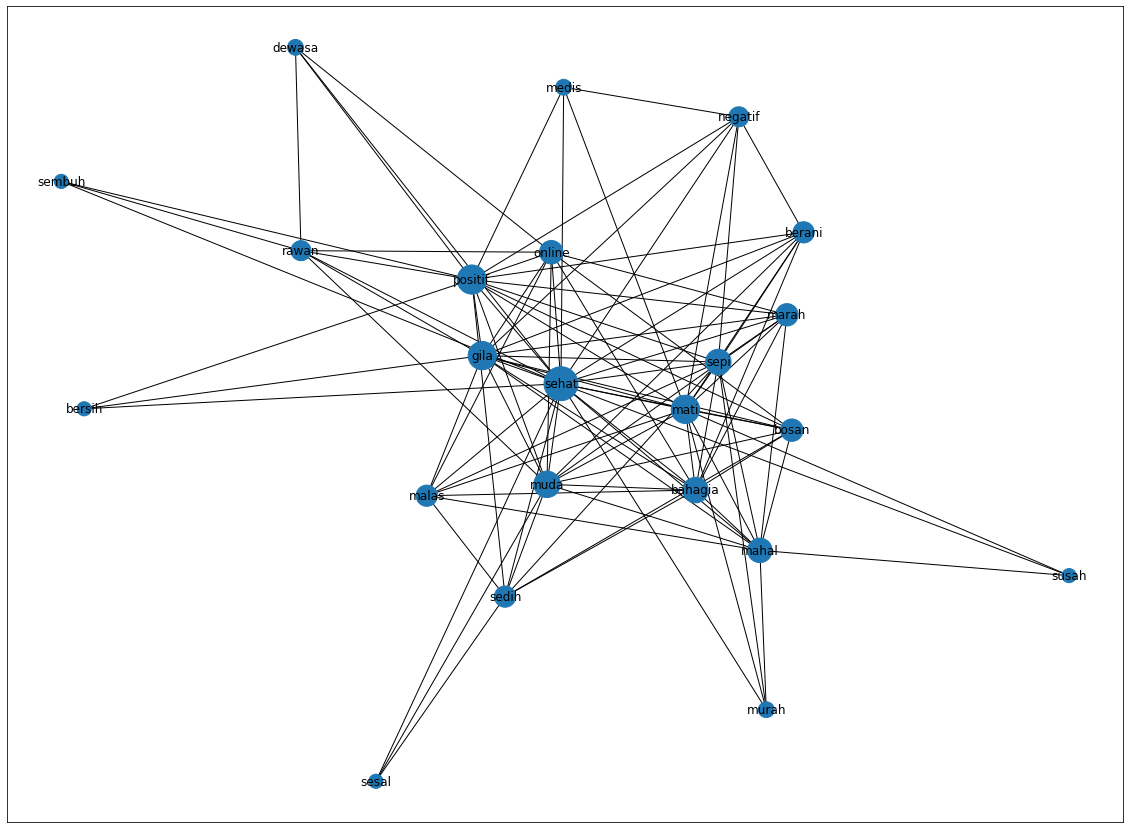

In [ ]:
plt.figure(figsize=(20,15))
pos = nx.spring_layout(ert_graph_data)
degrees = nx.degree(ert_graph_data)
#node_color = [ert_graph_data.node[node]['color'] for node in ert_graph_data]
node_size = [(degrees[v] + 1) * 50.0 for v in ert_graph_data.nodes()]
#edge_color = [ert_graph_data[u][v]['color'] for u,v in ert_graph_data.edges()]

nx.draw_networkx(ert_graph_data, pos=pos, cmap=plt.cm.PiYG, 
                 node_size=node_size,
                 with_labels=True)

**2.2 Graf Emotion Recall Task berdasarkan Skor Valensi**

Melakukan import data skor valensi berdasarkan leksikon InSet

In [ ]:
inset_negative = pd.read_csv('resources/inset/negative.tsv', sep = '\t')
inset_positive = pd.read_csv('resources/inset/positive.tsv', sep = '\t')

Menghitung nilai rata-rata skor valensi berdasarkan leksikon inset

In [ ]:
rerata_valensi_list = []

adjective_list = list(ert_graph_data.nodes())

for adjective_words in adjective_list:
    
    tweet_data = user_data_df[user_data_df['adjective_word'] == adjective_words]
    
    total_valensi = 0
    total_data = 0
    
    for j, word in tweet_data.iterrows():
        
        try:
            if word['sentiment'] == 'negative':
                row = inset_negative[inset_negative['word'] == word['adjective_word']]
                skor_valensi = row['weight'][row['weight'].index[0]]
            elif word['sentiment'] == 'positive':
                row = inset_positive[inset_positive['word'] == word['adjective_word']]
                skor_valensi = row['weight'][row['weight'].index[0]]
            else:
                try:
                    row = inset_positive[inset_positive['word'] == word['adjective_word']]
                    skor_valensi = row['weight'][row['weight'].index[0]]
                except:
                    row = inset_negative[inset_negative['word'] == word['adjective_word']]
                    skor_valensi = row['weight'][row['weight'].index[0]]
                
            total_data = total_data + 1
            total_valensi = total_valensi + skor_valensi
                 
        except:
            pass
    try:            
        rerata_valensi = (total_valensi/total_data)
    except:
        rerata_valensi = 0

    rerata_valensi_list.append(round(rerata_valensi, 2))

Menampilkan jaringan graf berdasarkan nilai skor valensi

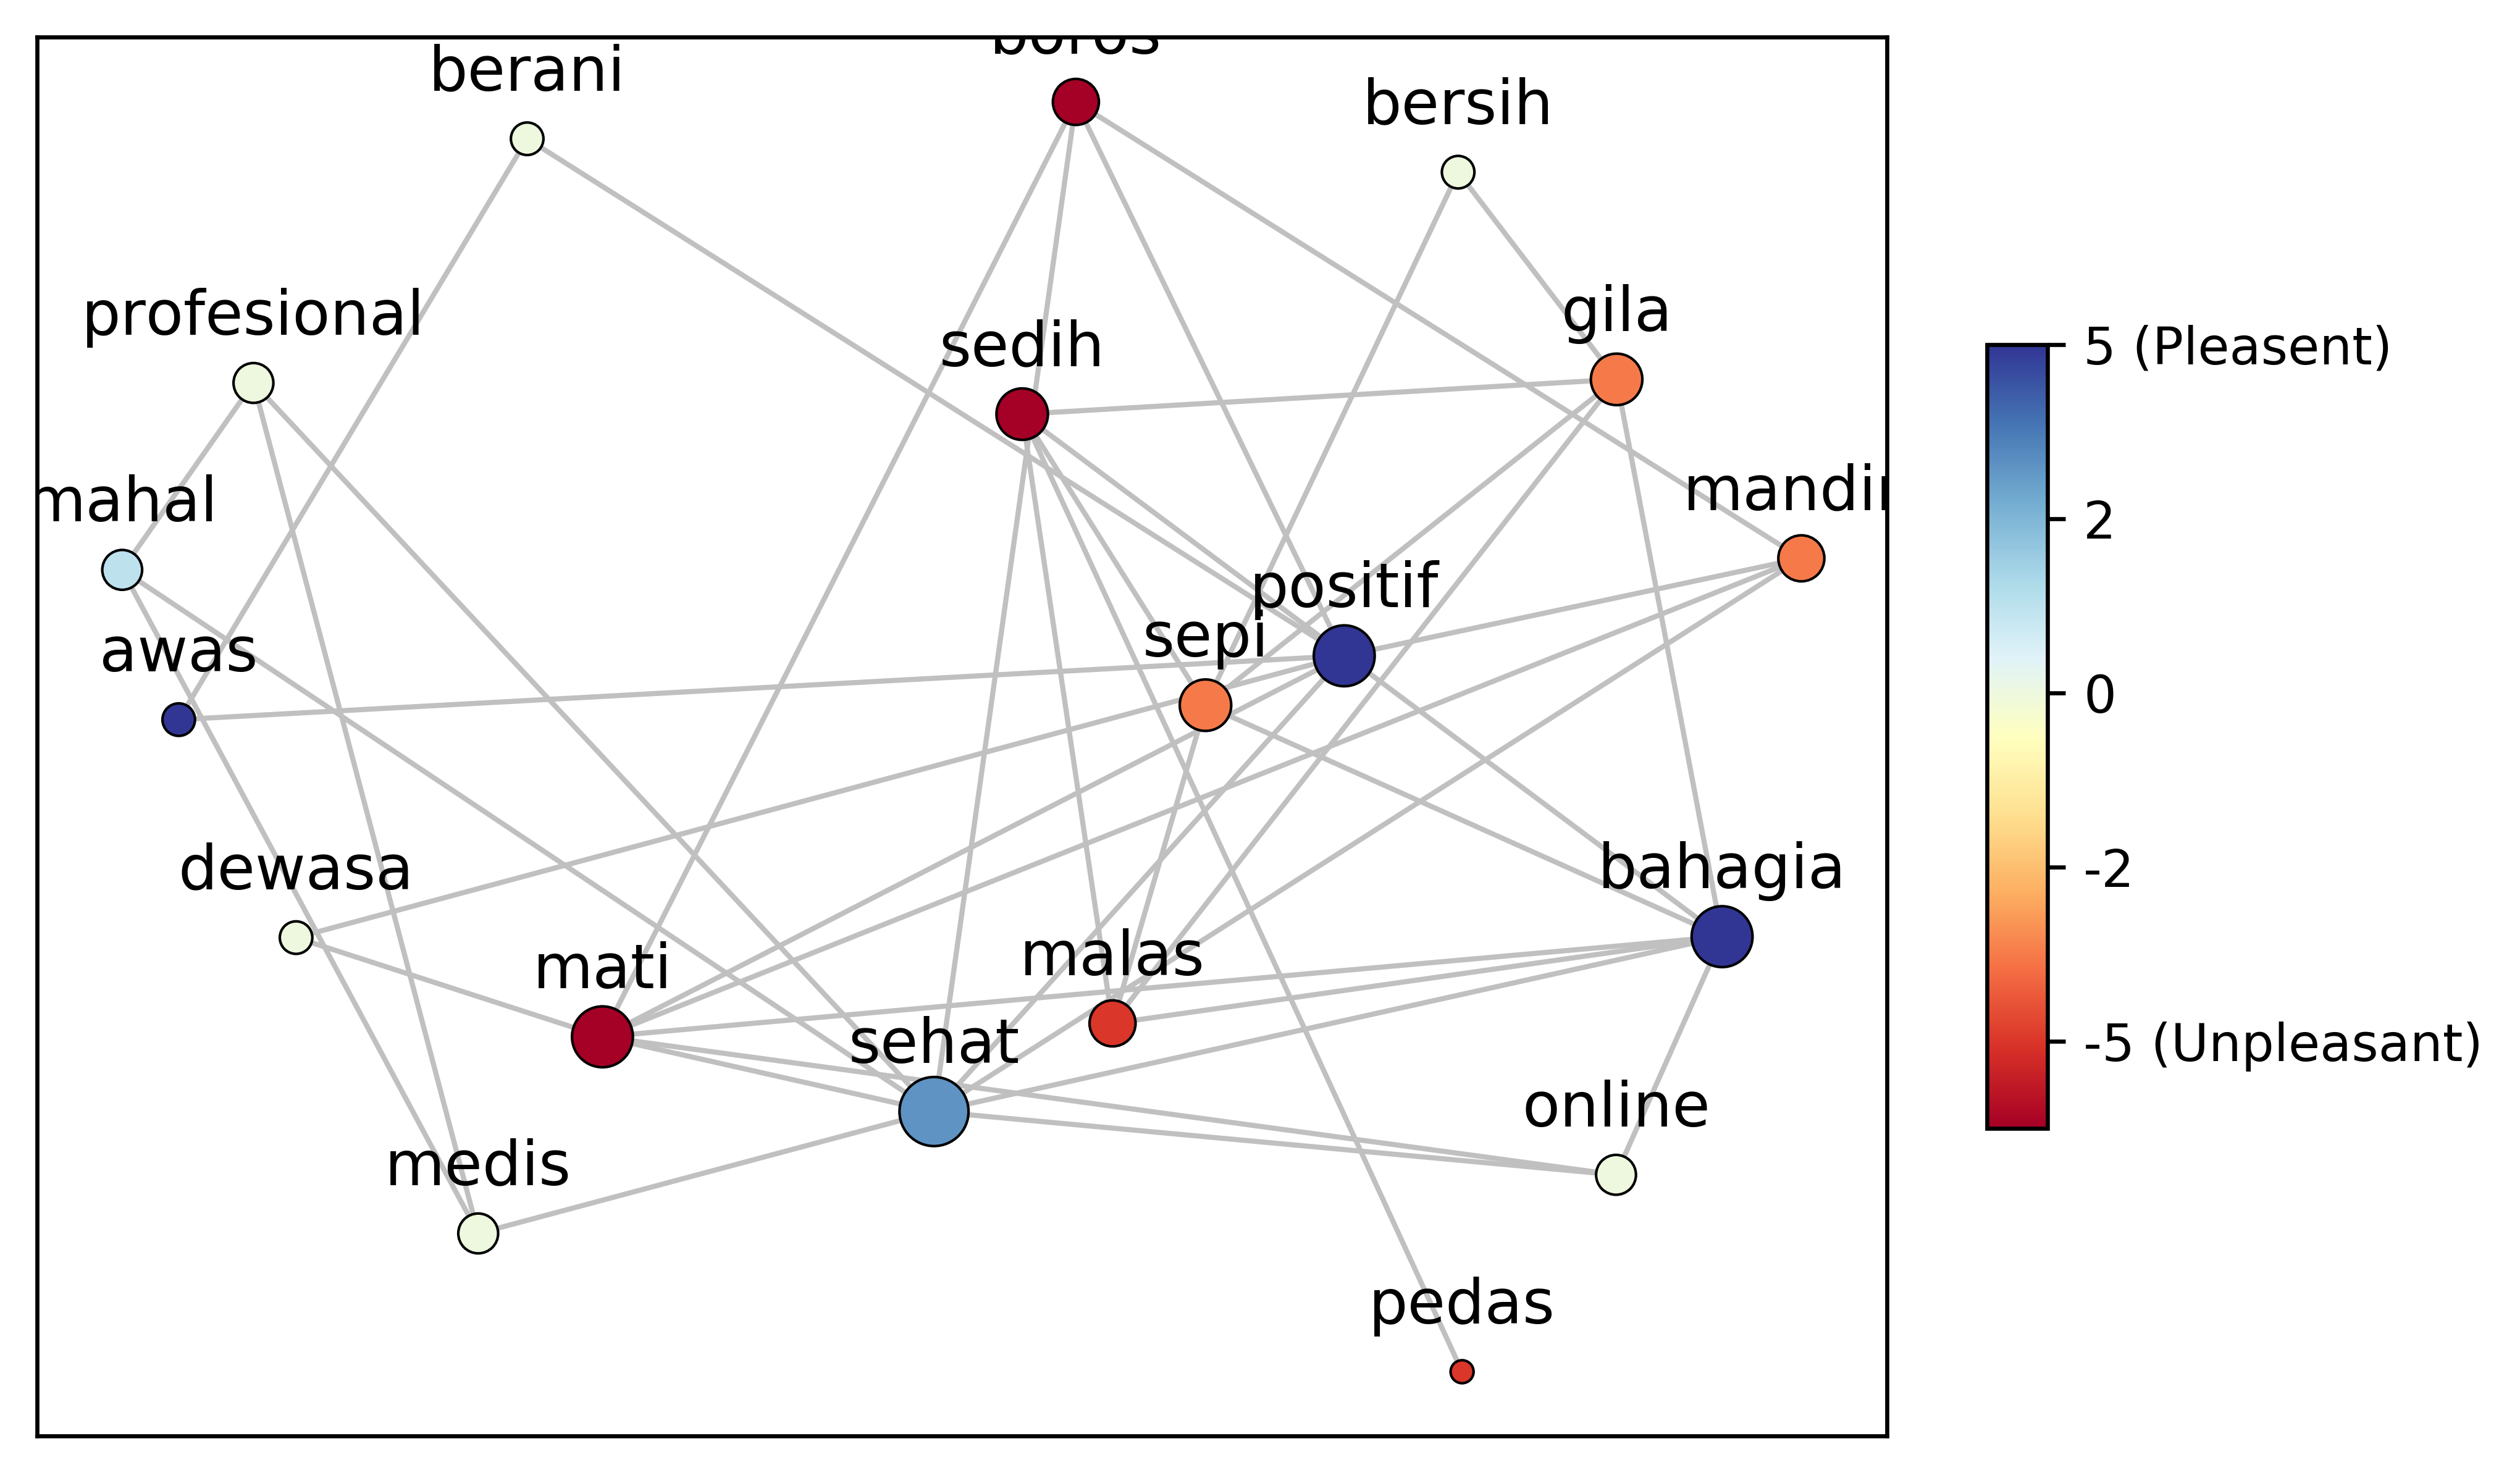

In [ ]:
#G = nx.karate_club_graph()
plt.figure(figsize=(7, 5), dpi=600)
ert_graph_df = (pd.DataFrame(list(ert_graph_data.degree), columns=['node','degree'])
        .set_index('node'))
ert_graph_df['color'] = rerata_valensi_list

#vmin = -5
#vmax = 5
vmin = ert_graph_df['color'].min()
vmax = ert_graph_df['color'].max()
cmap = plt.cm.RdYlBu

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(ert_graph_data, k=1.5, iterations=30)
pos_nodes = nudge(pos, 0, 0.1)
degrees = nx.degree(ert_graph_data)
node_size = [(degrees[v] * 20) for v in ert_graph_data.nodes()]

nx.draw_networkx(ert_graph_data, pos=pos, node_size=node_size, with_labels=False, 
                 node_color=ert_graph_df['color'], font_size=7, font_color='#000000', edge_color='#C0C0C0',
                 cmap=cmap, vmin=vmin, vmax=vmax, linewidths=0.5)
nx.draw_networkx_labels(ert_graph_data, pos=pos_nodes)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor("#000000")
#plt.margins(0.1, 0.1)
cbar = plt.colorbar(sm, aspect=13, fraction=0.03)
cbar.ax.set_yticklabels(['-5 (Unpleasant)', '-2', '0', '2', '5 (Pleasent)'])
#cbar.ax.tick_params(labelsize=3)

#plt.savefig('dataset/output/image_data_{}.png'.format(cluster_number), dpi=600)